# Chapter 1: Greenhouses Gases - The prime suspect

### Generation of plots inspired by [the relevant Climate Indicators' report](https://climate.copernicus.eu/climate-indicators/greenhouse-gas-concentrations).

### Section 1. Installing & importing the necessary packages.

In [1]:
# CDS API
import cdsapi

# Library for working with 2-d arrays
import pandas as pd

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
# import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotx

# import cartopy.crs as ccrs
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
# import cartopy.feature as cfeature

# operating system interfaces library
import os

# String operations
from string import ascii_lowercase as ABC

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

plt.style.use('copernicus.mplstyle')

### Section 2. Downloading data from CDS and ADS.

In [2]:
dir_loc = 'data/' # assign folder for storing the downloaded data
os.makedirs(dir_loc, exist_ok=True) # create the folder if not available

In [199]:
# get one slice of land-sea mask from ERA5 data that will be used ater on for the GHG analysis.
# Note that the resolution (grid) should be specified, because the original one (0.25) is different that the resolution of GHG (0.75).
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
     'product_type': 'reanalysis',
     'variable': 'land_sea_mask',
     'year': '2009',
     'month': '10',
     'day': '16',
     'time': '00:00',
     'grid': [0.75, 0.75],
     'format': 'netcdf',
    },
    f'{dir_loc}land_sea_mask.nc')

2023-05-22 14:48:44,282 INFO Welcome to the CDS
2023-05-22 14:48:44,284 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-05-22 14:48:44,585 INFO Request is queued
2023-05-22 14:48:45,642 INFO Request is running
2023-05-22 14:48:47,231 INFO Request is completed
2023-05-22 14:48:47,234 INFO Downloading https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data1/adaptor.mars.internal-1684759725.4378736-5436-9-642fc9a5-ed52-48c6-8509-fa662ec44f2c.nc to data/land_sea_mask.nc (229.8K)
2023-05-22 14:48:48,306 INFO Download rate 215K/s  


Result(content_length=235364,content_type=application/x-netcdf,location=https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data1/adaptor.mars.internal-1684759725.4378736-5436-9-642fc9a5-ed52-48c6-8509-fa662ec44f2c.nc)

In [200]:
ads_url = 'YOUR_URL'
ads_key = 'YOUR_KEY'

c = cdsapi.Client(url=ads_url, key=ads_key)
c.retrieve(
    'cams-global-ghg-reanalysis-egg4-monthly',
    {
     'product_type': 'monthly_mean',
     'variable': ['ch4_column_mean_molar_fraction', 'co2_column_mean_molar_fraction'], # get the available variables
     'year': list(range(2003, 2021)), # get all available years (2003, 2004, ..., 2020)
     'month': list(range(1, 13)), # get all months Jan (1) up to Dec (12)
     'format': 'netcdf',
    },
    f'{dir_loc}greenhouse_gases.nc')

AssertionError: The cdsapi key provided is not the correct format, please ensure it conforms to:
<UID>:<APIKEY>

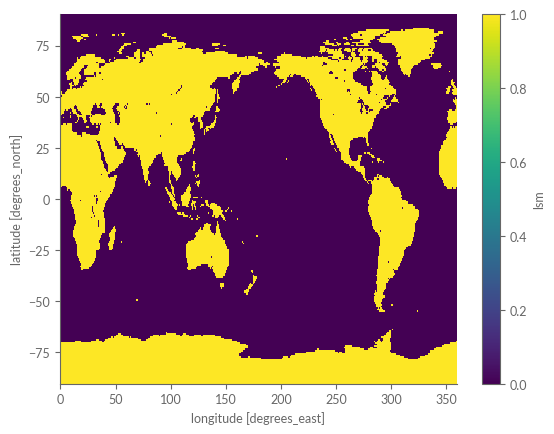

In [3]:
# read the land-sea mask and visualize ("quick and dirty") the data
data_mask = xr.open_dataarray(f'{dir_loc}land_sea_mask.nc').isel(time=0, drop=True)
is_land = data_mask >= 0.5
is_land.plot()

In [4]:
# open the GHG data and inspect the Dataset
# when the data are opened as below using "with" then the link to the actual dataset is closed, meaning that any other program can also access the file in the directory
# this is not the case for the normal opening of the file, as for the data_mask
with xr.open_dataset(f'{dir_loc}greenhouse_gases.nc') as ghg:
  pass
ghg

<xarray.Dataset>
Dimensions:    (longitude: 480, latitude: 241, time: 216)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.0 357.8 358.5 359.2
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2020-12-01
Data variables:
    tcch4      (time, latitude, longitude) float32 ...
    tcco2      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-13 13:14:27 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

### Section 3. Calculating and plotting the quantities of interest.

#### Monthly mean quantities across land for 60N-60S latitudes. 

The data are projected in lat/lon system. This system does not have equal areas for all grid cells, but as we move closer to the poles, the area of the cells is reducing. These differences can be accounted when weighting the cells with the cosine of their latitude.

In [5]:
wgts = np.cos(np.deg2rad(ghg.latitude)).clip(0, 1) # coslat for weights on spatial averaging. 
wgts # the clip function above is for reassuring that all values will be between 0-1 regardless of the  of machine's precision

<xarray.DataArray 'latitude' (latitude: 241)>
array([0.        , 0.0130896 , 0.02617699, 0.03925979, 0.05233597,
       0.06540319, 0.07845908, 0.09150165, 0.10452842, 0.1175374 ,
       0.13052624, 0.1434926 , 0.15643449, 0.16934957, 0.18223551,
       0.19509035, 0.20791166, 0.22069745, 0.23344542, 0.24615327,
       0.25881907, 0.27144054, 0.28401536, 0.29654163, 0.30901697,
       0.32143947, 0.33380693, 0.34611705, 0.35836798, 0.3705574 ,
       0.38268346, 0.39474392, 0.4067366 , 0.41865978, 0.43051115,
       0.4422887 , 0.45399055, 0.4656145 , 0.47715878, 0.48862126,
       0.49999997, 0.5112931 , 0.5224986 , 0.5336145 , 0.54463905,
       0.55557024, 0.56640625, 0.57714516, 0.58778524, 0.5983246 ,
       0.6087614 , 0.61909395, 0.6293204 , 0.639439  , 0.64944804,
       0.6593458 , 0.66913056, 0.67880076, 0.68835455, 0.69779044,
       0.70710677, 0.716302  , 0.72537434, 0.7343225 , 0.7431448 ,
       0.7518398 , 0.76040596, 0.7688418 , 0.777146  , 0.78531694,
       0.7933533 , 0.8012538 , 0.809017  , 0.81664157, 0.8241262 ,
       0.8314696 , 0.83867055, 0.8457278 , 0.85264015, 0.8594064 ,
       0.8660254 , 0.872496  , 0.87881714, 0.88498765, 0.8910065 ,
       0.89687276, 0.90258527, 0.90814316, 0.9135454 , 0.91879123,
       0.9238795 , 0.9288095 , 0.9335804 , 0.93819135, 0.9426415 ,
       0.9469301 , 0.95105654, 0.95501995, 0.95881975, 0.9624552 ,
...
       0.9469301 , 0.9426415 , 0.93819135, 0.9335804 , 0.9288095 ,
       0.9238795 , 0.91879123, 0.9135454 , 0.90814316, 0.90258527,
       0.89687276, 0.8910065 , 0.88498765, 0.87881714, 0.872496  ,
       0.8660254 , 0.8594064 , 0.85264015, 0.8457278 , 0.83867055,
       0.8314696 , 0.8241262 , 0.81664157, 0.809017  , 0.8012538 ,
       0.7933533 , 0.78531694, 0.777146  , 0.7688418 , 0.76040596,
       0.7518398 , 0.7431448 , 0.7343225 , 0.72537434, 0.716302  ,
       0.70710677, 0.69779044, 0.68835455, 0.67880076, 0.66913056,
       0.6593458 , 0.64944804, 0.639439  , 0.6293204 , 0.61909395,
       0.6087614 , 0.5983246 , 0.58778524, 0.57714516, 0.56640625,
       0.55557024, 0.54463905, 0.5336145 , 0.5224986 , 0.5112931 ,
       0.49999997, 0.48862126, 0.47715878, 0.4656145 , 0.45399055,
       0.4422887 , 0.43051115, 0.41865978, 0.4067366 , 0.39474392,
       0.38268346, 0.3705574 , 0.35836798, 0.34611705, 0.33380693,
       0.32143947, 0.30901697, 0.29654163, 0.28401536, 0.27144054,
       0.25881907, 0.24615327, 0.23344542, 0.22069745, 0.20791166,
       0.19509035, 0.18223551, 0.16934957, 0.15643449, 0.1434926 ,
       0.13052624, 0.1175374 , 0.10452842, 0.09150165, 0.07845908,
       0.06540319, 0.05233597, 0.03925979, 0.02617699, 0.0130896 ,
       0.        ], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
Attributes:
    units:      degrees_north
    long_name:  latitude

In [6]:
ghg_land = ghg.where(is_land)
ghg_land = ghg_land.sel(latitude=slice(60, -60)) # keep only land data between 60N-60S

smoothed_n_months = 12 # define the number of months used for the temporal smoothing
spatial_average = ghg_land.weighted(wgts).mean(['latitude', 'longitude']).assign_coords({'type': 'monthly'}) # spatial average

spatial_average_smoothed = spatial_average.rolling(time=smoothed_n_months, min_periods=1, center=True).mean()
spatial_average_smoothed = spatial_average_smoothed.assign_coords({'type': f'{smoothed_n_months}-month smoothed'}) # smoothed n-month spatial average

spatial_average = xr.concat([spatial_average, spatial_average_smoothed], dim='type') # combine

In [7]:

growth_rate = (spatial_average_smoothed-spatial_average_smoothed.shift(time=1))
monthly_growth_rate_mean = growth_rate.groupby('time.year').mean()
monthly_growth_rate_stdev = growth_rate.groupby('time.year').std()

annual_growth_rate_mean = 12 * monthly_growth_rate_mean
annual_growth_rate_stdev = np.sqrt(12 * monthly_growth_rate_stdev**2)

In [8]:
# get the date that the CO2 concetrations exceeded 400 ppm for the first time
is_above_400 = spatial_average['tcco2'].sel(type='monthly') >= 400
idx_first_time_step_above_400 = is_above_400.argmax(dim='time', skipna=True)
idx_first_time_step_above_400

first_time_400 = spatial_average['tcco2'].time.isel(time=idx_first_time_step_above_400).values
first_time_400 = pd.to_datetime(first_time_400)

In [9]:
# auxiliary data used for plotting
prop_cycle_clrs = plt.rcParams['axes.prop_cycle'].by_key()['color']

aux_var = {
    'tcco2': {'name':'Atmospheric carbon dioxide', 'units': 'ppm', 'shortname': r'CO$_{2}$', 'color': prop_cycle_clrs[0]},
    'tcch4': {'name':'Atmospheric methane', 'units': 'ppb', 'shortname': r'CH$_{4}$', 'color': prop_cycle_clrs[1]},
}
subtitles = ['CO$_2$ (ppm/year)', 'CH$_4$ (ppb/year)']

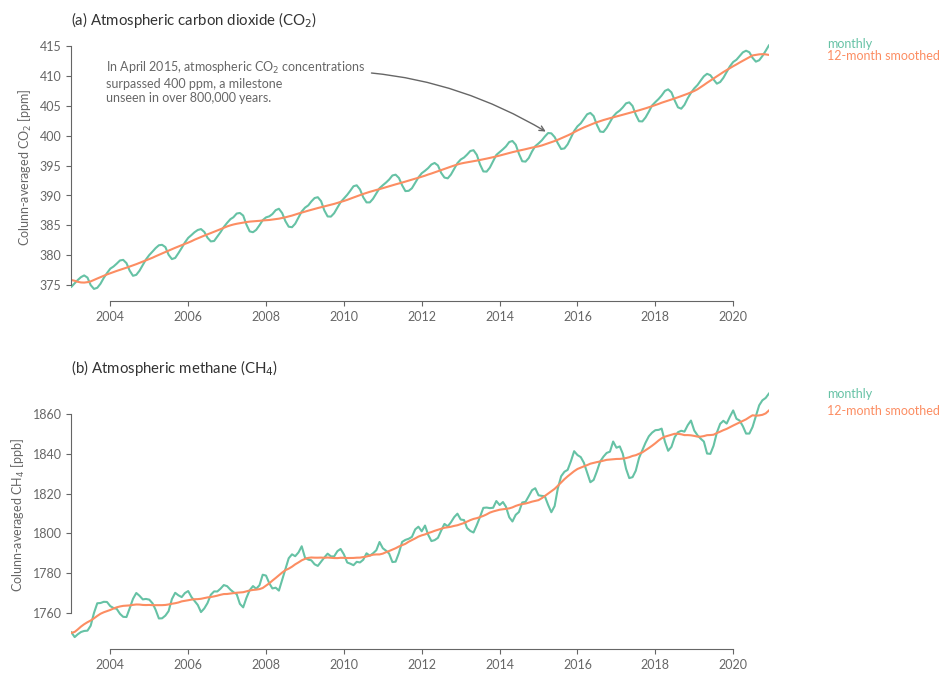

In [26]:

fig, ax = plt.subplots(2, 1, figsize=(9, 8))
ax = ax.flatten()

for i, molecule in enumerate(['tcco2', 'tcch4']):
  
  yy_all = [spatial_average[molecule].sel(type=i_type).values for i_type in spatial_average.type.values]
  for yy, label in zip(yy_all, spatial_average.type.values):
      ax[i].plot(spatial_average.time.values, yy, label=label) 
  
  matplotx.line_labels(ax=ax[i]) # add legend as colored text next to the right end of the relevant line
  
  ax[i].set_xlim(spatial_average[molecule].time.values[0], spatial_average[molecule].time.values[-1])
  ax[i].set_title(f'({ABC[i]}) ' + aux_var[molecule]['name'] + ' (' + aux_var[molecule]['shortname'] + ')')
  ax[i].set_ylabel('Colunn-averaged '+ aux_var[molecule]['shortname']  + ' [' + aux_var[molecule]['units'] + ']')

  sns.despine(ax=ax[i], trim=True) # trimming the y and x axis to be visible only from the fist till the last tick
  ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # the formatting is needed because the above line breaks the time format of the x axis
  if molecule=='tcco2':
    # Place a text in the first axis with an arrow pointing to the maximum value in axis 0
    desc = 'In ' + first_time_400.strftime('%B %Y') + ', atmospheric CO$_2$ concentrations \nsurpassed 400 ppm, a milestone \nunseen in over 800,000 years.'
    ax[i].annotate(
                    desc,
                    xy=(first_time_400, spatial_average['tcco2'].sel(type='monthly', time=first_time_400).values),
                    xytext=(0.05, 0.9),
                    textcoords=ax[i].transAxes,
                    ha='left', va='top',
                    arrowprops=dict(arrowstyle='->', color='.4', connectionstyle='arc3,rad=-0.2')
                  )

plt.subplots_adjust(hspace=.3)


Text(0.0, 1.0, 'Annual growth rates of greenhouse gases')

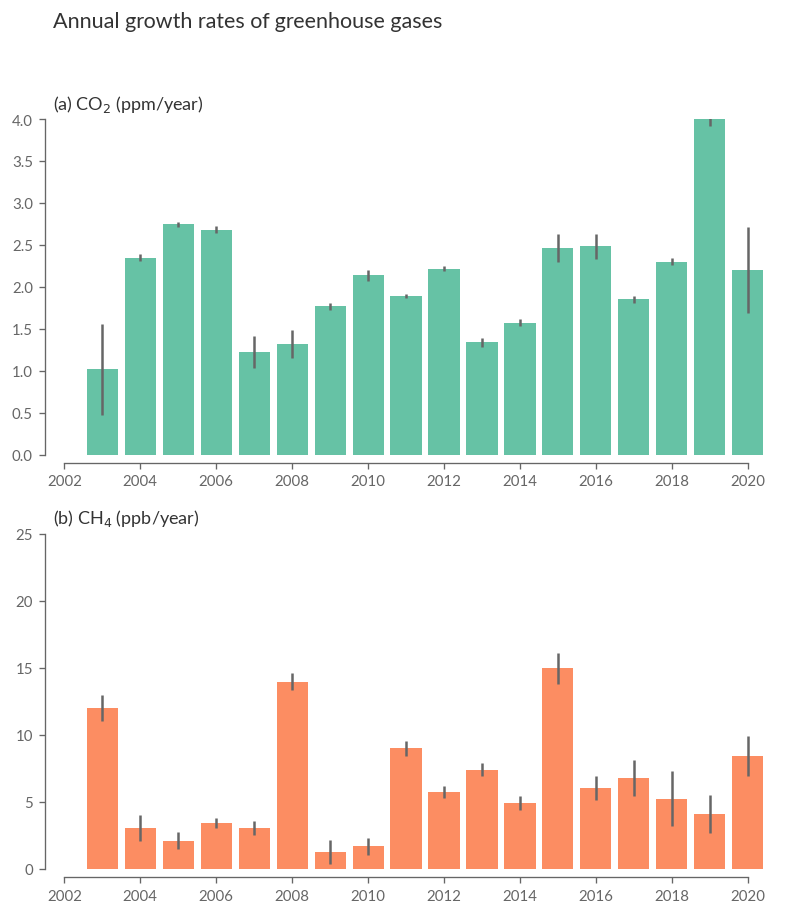

In [14]:
import datetime
from matplotlib.gridspec import GridSpec



subtitles = ['CO$_2$ (ppm/year)', 'CH$_4$ (ppb/year)']

fig = plt.figure(figsize=(8, 9), dpi=120)
gs = GridSpec(3, 1, figure=fig, height_ratios=[.01, 1, 1], hspace=0.35)

tax = fig.add_subplot(gs[0, 0])
axes = [fig.add_subplot(gs[i, 0]) for i in range(1, 3)]

years = pd.to_datetime(annual_growth_rate_mean.year.values, format='%Y')

axes[0].set_ylim(0, 4)
axes[1].set_ylim(0, 25)
for ax, abc, molecule, title in zip(axes, ABC, ['tcco2', 'tcch4'], subtitles):
    ax.bar(years, annual_growth_rate_mean[molecule], width=datetime.timedelta(days=300), color=aux_var[molecule]['color'])
    ax.errorbar(years, annual_growth_rate_mean[molecule], yerr=annual_growth_rate_stdev[molecule], ls='', color='.4')
    ax.set_title(f'({abc}) ' + title)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    sns.despine(ax=ax, trim=True, offset=5)
tax.axis('off')
tax.set_title('Annual growth rates of greenhouse gases', fontsize='x-large')
# tax.text(0, 0, 'in °C', ha='left', va='top', transform=tax.transAxes)


#### Monthly mean anomalies.

The above figures indicate a consistent increase for both GHG. Since they have different magnitudes though, its hard to compare if there is difference in the rate of increase. One way to overcome this challenge and have them in the same plot, is to calculate their anomalies from climatological conditions.</br>
To calculate anomalies normally at least 30 years of data are required. This is not valid for our dataset, but we nevertheless perform the analysis as a demonstration. Moreover, the correct is to get anomalies based on monthly mean and std. This is not really valid in our case though, because there is a very strong increasing trend in the GHG, which makes the seasonal cycle affected (check dirty plot below)

In [15]:
# what is normally done when the variable has a 'stationary' behaviour
climatology_mean = spatial_average.groupby('time.month').mean('time') # climatological mean for each month
climatology_std = spatial_average.groupby('time.month').std('time') # climatological standard deviation for each month
anomalies = (spatial_average.groupby('time.month') - climatology_mean)
anomalies = anomalies.groupby('time.month')/climatology_std

# what is done in this case due to the high influence of the trend to the results
anomalies = (spatial_average-spatial_average.mean('time'))/spatial_average.std('time')

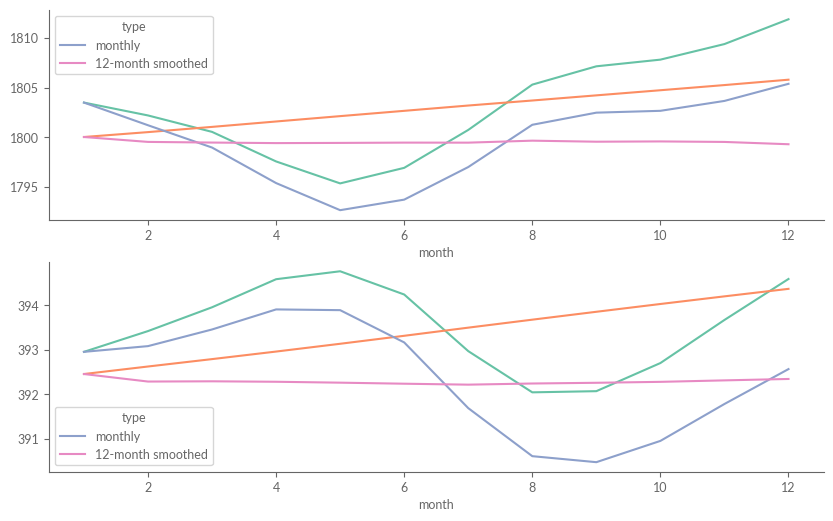

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
climatology_mean['tcch4'].sel().plot(hue='type', ax=ax[0])
stationary = xr.concat([(0*climatology_mean['tcch4'].sel(month=1)), climatology_mean['tcch4'].diff('month')], dim='month')
(climatology_mean['tcch4']-stationary.sel(type='12-month smoothed', drop=True)*stationary.month).plot(hue='type', ax=ax[0])
climatology_mean['tcco2'].sel().plot(hue='type', ax=ax[1])
stationary = xr.concat([(0*climatology_mean['tcco2'].sel(month=1)), climatology_mean['tcco2'].diff('month')], dim='month')
(climatology_mean['tcco2']-stationary.sel(type='12-month smoothed', drop=True)*stationary.month).plot(hue='type', ax=ax[1])
# del(climatology_mean, climatology_std, stationary)

Notice the difference in the values between January mean state and December mean state for both GHG (blue lines). This indicates that on average just in the course of 1 single year there is already a substantial increase in the concentrations, that do alter the expected seasonal cycle, as we normally would expect to see the Jan and Dec values being very very close. Especially by checking the smoothed data (orange lines), the increasing trend of the mean state at each month is clearly evident.

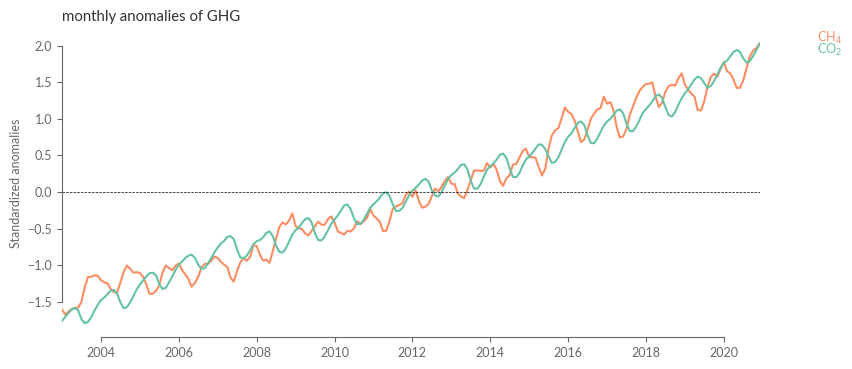

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4))

label_all = [aux_var[i]['shortname'] for i in list(anomalies.keys())]
color_all = [aux_var[i]['color'] for i in list(anomalies.keys())]
yy_all = [anomalies[i_var].sel(type='monthly').values for i_var in anomalies.keys()]
for yy, label, color in zip(yy_all, label_all, color_all):
    ax.plot(anomalies.time.values, yy, label=label, color=color)      
matplotx.line_labels(ax=ax) # add legend as colored text next to the right end of the relevant line

# anomalies.sel(type='monthly', drop=True).to_array().plot(hue='variable', linewidth=2, ax=ax)
ax.axhline(0, color='k', ls='--', lw=0.5)
ax.set_xlim(anomalies.time.values[0], anomalies.time.values[-1])
ax.set_title('monthly anomalies of GHG')
ax.set_ylabel('Standardized anomalies')
# ax.legend([aux_var[i]['shortname'] for i in list(anomalies.keys())])
sns.despine(ax=ax, trim=True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
del(fig, ax, label_all, color_all, yy_all, yy, label, color)

The above plot shows us that the degree of increase is quite similar for both GHG and their behaviour has only small differences in a subset of the analyzed years.

#### Observe different behaviour across the two hemispheres.

In [20]:
studied_domains = {
                  'Global': {'latitude': slice(90, -90)},
                  'Northern Hemishpere': {'latitude': slice(90, 0)},
                  'Southern Hemisphere': {'latitude': slice(0, -90)}
                  }

In [23]:
mean_domains = []
for i, domain in studied_domains.items():
  i_data_subset = ghg_land.sel(domain) # keep only land data between 60N-60S
  i_spatial_average = i_data_subset.weighted(wgts).mean(['latitude', 'longitude']) # spatial average
  mean_domains.append( i_spatial_average.assign_coords({'domain': i}) )

mean_domains = xr.concat(mean_domains, dim='domain')

# all the above can be also written in 2 lines based on list-comprehension as below
mean_domains = [ghg_land.sel(domain).weighted(wgts).mean(['latitude', 'longitude']) for domain in studied_domains.values()]
mean_domains = xr.concat(mean_domains, dim=pd.Index(studied_domains.keys(), name='domain'))

del(i, j, studied_domains)

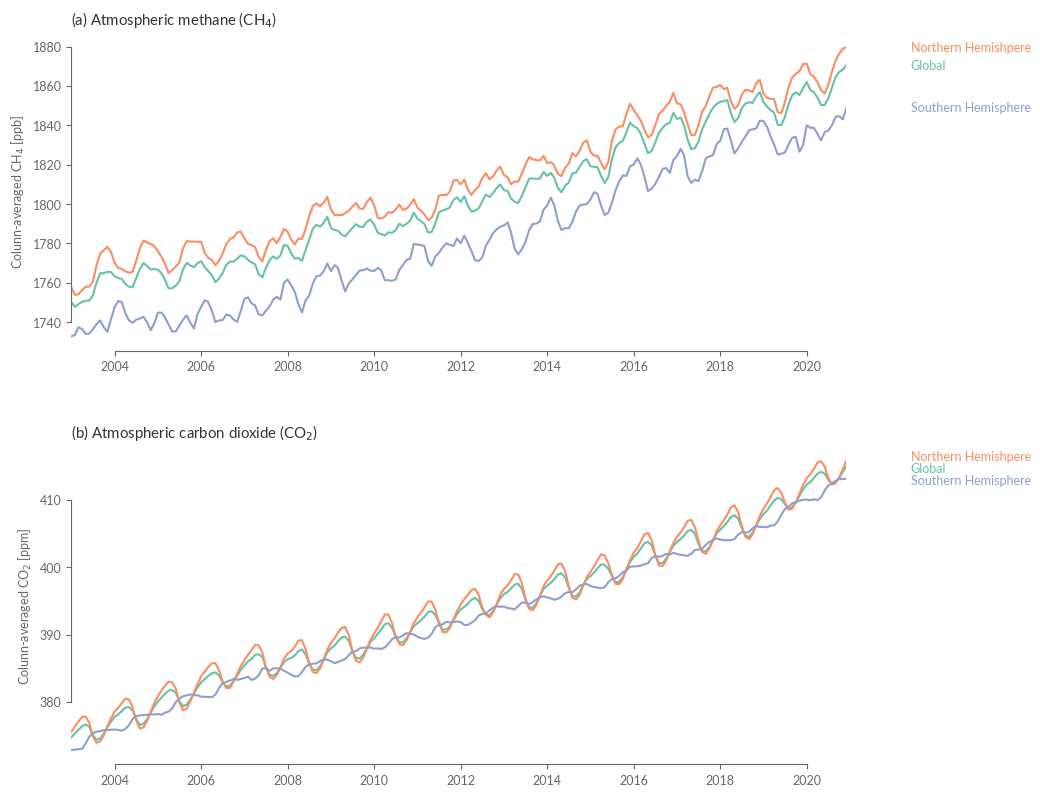

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(10, 9.5))
ax = ax.flatten()
for i, j in enumerate(mean_domains.keys()):

  yy_all = [mean_domains[j].sel(domain=i_dom).values for i_dom in mean_domains.domain.values]
  for yy, label in zip(yy_all, mean_domains.domain.values):
      ax[i].plot(mean_domains.time.values, yy, label=label) 
  matplotx.line_labels(ax=ax[i]) # add legend as colored text next to the right end of the relevant line

  # mean_domains[j].plot(hue='domain', linewidth=2, ax=ax[i])
  ax[i].set_xlim(mean_domains[j].time.values[0], mean_domains[j].time.values[-1])
  ax[i].set_title(f'({ABC[i]}) '+ aux_var[j]['name'] + ' (' + aux_var[j]['shortname'] + ')')
  ax[i].set_ylabel('Colunn-averaged '+ aux_var[j]['shortname']  + ' [' + aux_var[j]['units'] + ']')

  sns.despine(ax=ax[i], trim=True) # trimming the y and x axis to be visible only from the fist till the last tick
  ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # the formatting is needed because the above line breaks the time format of the x axis
  
plt.subplots_adjust(hspace=.3)
del(fig, ax, i, j)

#### Spatial characteristics.

All previous plots refer to areal averaged analysis. We have already seen that north and south hemisphere have quite different behaviour in terms of magnitude and also seasonal fluctuations. Let's see now if there are more differences across regions, by plotting the data in space for selected periods of time.

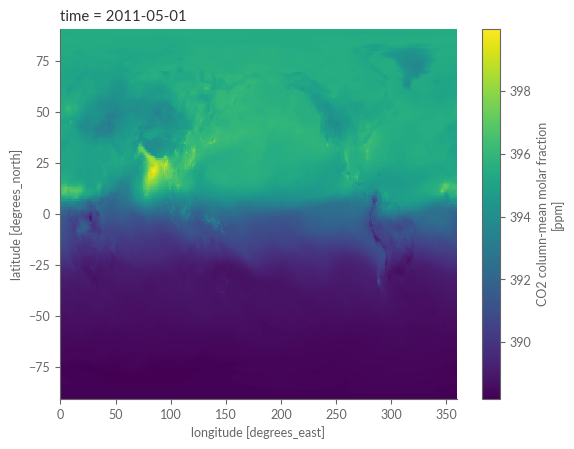

In [25]:
ghg['tcco2'].isel(time=100).plot()

### Section 4. Useful links
For the ones interested in finding out more about GHG, please find below some links for relevant articles and visualizations:
1. [Greenhouse gas concentrations Climate Indicators Report](https://climate.copernicus.eu/climate-indicators/greenhouse-gas-concentrations)
2. [Global Monitorin Laboratory](https://gml.noaa.gov/ccgg/) from [NOAA](https://www.noaa.gov/), with a lot of information, relevant plots, and raw data that can be freely donwloaded. 
3. Lashof, D., Ahuja, D. Relative contributions of greenhouse gas emissions to global warming. Nature 344, 529–531 (1990). https://doi.org/10.1038/344529a0
4. 